In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
fileList = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        fileList.append(filename)
        print(os.path.join(dirname, filename))
print(fileList)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-data/preprocessedData.csv
/kaggle/input/preprocessed-data/submitInput.csv
/kaggle/input/preprocessed-data/solution.csv
/kaggle/input/preprocessed-data/__results___files/__results___36_1.png
/kaggle/input/full-sentence-dataset/preprocessedData.csv
/kaggle/input/full-sentence-dataset/submitInput.csv
/kaggle/input/wrong-predicted-data/check (2).csv
/kaggle/input/classifying-contest/submission_file.csv
/kaggle/input/classifying-contest/data.csv
/kaggle/input/encodeddata/encodedData.txt
/kaggle/input/encodeddata/encoded_model_data.txt
/kaggle/input/code-table/code.csv
./__notebook__.ipynb
['__notebook__.ipynb']


In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 602 kB/s            
     |████████████████████████████████| 448 kB 64.3 MB/s            


In [3]:
import numpy as np
import pandas as pd
from konlpy.tag import Okt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Important Hyperparameter**

In [4]:
BATCH_SIZE = 200
EPOCH_A = 45
EPOCH_B = 50
STEP = 700
how_to_split = 800000

VECTOR_SIZE = 1300

In [5]:
raw_data = pd.read_csv("../input/encodeddata/encodedData.txt", sep='|')
raw_model_data = pd.read_csv("../input/encodeddata/encoded_model_data.txt", sep='|')

In [6]:
def code_table():
    code_table = pd.read_csv("../input/code-table/code.csv", sep=',')
    code_table = code_table[code_table['member'].notnull()]
    code_table = code_table.reset_index(drop=True)
    code_table = code_table.fillna(method='pad')
    code_table['member'] = code_table['member'].astype(int)
    return code_table

def preprocessInput(data):
    tem_input = []
    for i in range(len(data['sentence'])):
        if (i%100) == 0:
            print('.', end = ' ')
        if (i%5000) == 0:
            print(i, '\n', end = ' ')
        tokenized_sentence = okt.morphs(str(data['sentence'][i]), stem=True)
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
        joined_word = ' '.join(stopwords_removed_sentence)
        tem_input.append(joined_word)
    return tem_input

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

def make_graphs(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)


# LOOK AHEAD THE DATA

In [7]:
stopwords = ['갖추다','에서','의','가','을','이','은','들','는','에의','잘','과','도','를','으로','자','에','와','한','하다','에게','일반','및','등','로']
okt = Okt()

In [8]:
raw_model_data = raw_model_data.fillna(' ')
raw_model_data['sentence'] = raw_model_data['text_obj'] +' '+raw_model_data['text_mthd'] +' '+ raw_model_data['text_deal']
raw_model_data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,sentence
0,id_000001,,,,치킨전문점에서,고객의주문에의해,치킨판매,치킨전문점에서 고객의주문에의해 치킨판매
1,id_000002,,,,산업공구,다른 소매업자에게,철물 수공구,산업공구 다른 소매업자에게 철물 수공구
2,id_000003,,,,절에서,신도을 대상으로,불교단체운영,절에서 신도을 대상으로 불교단체운영
3,id_000004,,,,영업장에서,고객요구로,자동차튜닝,영업장에서 고객요구로 자동차튜닝
4,id_000005,,,,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공","실내포장마차에서 접객시설을 갖추고 소주,맥주제공"
...,...,...,...,...,...,...,...,...
99995,id_099996,,,,사업장에서,일반인대상으로,버섯농장,사업장에서 일반인대상으로 버섯농장
99996,id_099997,,,,한의원에서,외래환자위주고,치료,한의원에서 외래환자위주고 치료
99997,id_099998,,,,일반점포에서,소비자에게,그림판매,일반점포에서 소비자에게 그림판매
99998,id_099999,,,,사업장에서,일반인.학생대상으로,학습공간제공,사업장에서 일반인.학생대상으로 학습공간제공


In [9]:
raw_data['sentence'] = raw_data['text_obj'] +' '+raw_data['text_mthd'] +' '+ raw_data['text_deal']
raw_data = raw_data.dropna()
raw_data = raw_data.reset_index();

In [10]:
raw_data.insert(5, "digit_4",raw_data['digit_3'].apply(lambda x:str(x)[-1:]),True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925009 entries, 0 to 925008
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   index      925009 non-null  int64 
 1   AI_id      925009 non-null  object
 2   digit_1    925009 non-null  object
 3   digit_2    925009 non-null  int64 
 4   digit_3    925009 non-null  int64 
 5   digit_4    925009 non-null  object
 6   text_obj   925009 non-null  object
 7   text_mthd  925009 non-null  object
 8   text_deal  925009 non-null  object
 9   sentence   925009 non-null  object
dtypes: int64(3), object(7)
memory usage: 70.6+ MB


# PREPROCESSING

In [11]:
def translate_to_id(target, id_dic):
    target = target.map(id_dic.get).dropna()
    return target

In [12]:
digit2_unique = raw_data['digit_2'].unique()
digit_2_id = {v:k for k,v in enumerate(digit2_unique)} #73

digit4_unique = raw_data['digit_4'].unique()
digit_4_id = {v:k for k,v in enumerate(digit4_unique)} #10

In [13]:
temp = raw_data['digit_4'].map(digit_4_id.get).dropna()
if len(temp) == len(raw_data):
    print('no-null')
    raw_data['digit_4'] = temp
    
temp = raw_data['digit_2'].map(digit_2_id.get).dropna()
if len(temp) == len(raw_data):
    print('no-null')
    raw_data['digit_2'] = temp
    
raw_data

no-null
no-null


,index,AI_id,digit_1,digit_2,digit_3,digit_4,text_obj,text_mthd,text_deal,sentence
0,0,id_0000001,S,0,952,0,카센터에서,자동차부분정비,타이어오일교환,카센터에서 자동차부분정비 타이어오일교환
1,1,id_0000002,G,1,472,0,상점내에서,일반인을 대상으로,채소.과일판매,상점내에서 일반인을 대상으로 채소.과일판매
2,2,id_0000003,G,2,467,1,절단하여사업체에도매,공업용고무를가지고,합성고무도매,절단하여사업체에도매 공업용고무를가지고 합성고무도매
3,3,id_0000004,G,1,475,2,영업점에서,일반소비자에게,열쇠잠금장치,영업점에서 일반소비자에게 열쇠잠금장치
4,4,id_0000005,Q,3,872,0,어린이집,보호자의 위탁을 받아,취학전아동보육,어린이집 보호자의 위탁을 받아 취학전아동보육
...,...,...,...,...,...,...,...,...,...,...
925004,999995,id_0999996,C,50,134,5,제품입고,워싱,청바지워싱,제품입고 워싱 청바지워싱
925005,999996,id_0999997,F,8,424,5,현장에서,고객의요청에의해,실내인테리어,현장에서 고객의요청에의해 실내인테리어
925006,999997,id_0999998,G,1,474,5,영업점에서,일반소비자에게,여성의류 판매,영업점에서 일반소비자에게 여성의류 판매
925007,999998,id_0999999,P,9,856,6,사업장에서,일반고객을대상으로,필라테스,사업장에서 일반고객을대상으로 필라테스


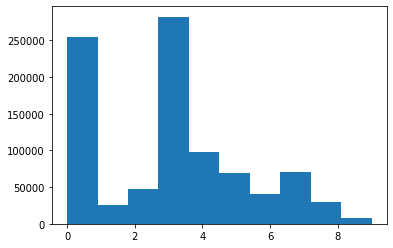

In [14]:
plt.hist(raw_data['digit_4'])
plt.show()

In [15]:
#미리 전처리한 파일이 있을때 쓰는 코드
X_train = pd.read_csv("../input/full-sentence-dataset/preprocessedData.csv", sep=',')
X_train.columns = ['index', 'words']
X_train = X_train['words'].tolist()
X_train = [str(X_train[i]).replace('일 반','일반') for i in range(len(X_train))]
X_train = [str(X_train[i]).replace('가지 고','가지다') for i in range(len(X_train))]

#새로운 전처리
# X_train = preprocessInput(raw_data)
# dataframe = pd.DataFrame(X_train)
# dataframe.to_csv("./preprocessedData.csv")

# PREPARE DATA

In [16]:
train_input = raw_data['sentence']
train_label = raw_data['digit_2']

train_input, val_input, train_label, val_label = \
    train_test_split(np.array(X_train), np.array(raw_data['digit_2'].tolist()), shuffle=True, test_size = 0.1)

In [17]:
train_input_B = raw_data['sentence']
train_label_B = raw_data['digit_4']

train_input_B, val_input_B, train_label_B, val_label_B = \
    train_test_split(np.array(X_train), np.array(raw_data['digit_4'].tolist()), shuffle=True, test_size = 0.1)

In [18]:
wrong_predicted =  pd.read_csv("../input/wrong-predicted-data/check (2).csv", sep=',')
wrong_predicted

,Unnamed: 0,prediction,label,sentence
0,20,9,6,"교양 , 철학 아카데미"
1,51,3,4,사업 장 소매업자 대상 식자 재다
2,52,1,2,연구 통 정책 연구개발
3,60,5,3,사업 장 산업 사용자 닭꼬치 도매
4,61,8,4,매장 일반인 대상 퀼트 부자 재판매
...,...,...,...,...
7345,64891,1,7,사업 장 급식 제조 하 여 지역 아동 센터 납품
7346,64956,3,6,산업 사용자 대상 건설 기계 임대 ( 지 입 서비스 )
7347,65005,1,8,제 탕 하 여 일반 소비자 에게 의약 제 탕
7348,65007,5,3,개인 기업 대상 판매 사업 장 지면 구입 하 여 재판매


In [19]:
wrong_predicted_sen = wrong_predicted['sentence'].tolist()
wrong_predicted_label = wrong_predicted['label'].tolist()

wrong_predicted_sen = np.array(wrong_predicted_sen)
wrong_predicted_label = np.array(wrong_predicted_label)

In [20]:
VOCAB_SIZE = VECTOR_SIZE 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(np.array(X_train))

2022-03-26 12:18:19.029856: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-26 12:18:20.158209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# CHECK VECTORLIZATION

In [21]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)
vocab[:100]

array(['', '[UNK]', '대상', '서비스', '고객', '장', '시설', '사업', '접객', '일반인', '판매',
       '일반', '운송', '소비자', '매장', '소매', '요청', '음식점', '제공', '화물', '화물자동차',
       '부동산', '도매', '중개', '개인', '택시', '승객', '받다', '영업', '교육', '제조', '사무실',
       '학원', '용달', '계약', '종교', '의뢰', '학생', '관리', '소매업자', '가공', '여', '의류',
       '커피', '위주', '자동차', '가게', '산업', '수리', '개별', '따르다', '소', '공사', '식료품',
       '염색', '현장', '부품', '미용실', '활동', '환자', '하', '운영', '용', '맥주', '미용',
       '음료', '주점', '파마', '전', '요구', '사용자', '교회', '건설', '건물', '외래', '진료',
       '업체', '음', '업', '한식', '치킨', '기계', '절단', '에의', '사', '제작', '여성',
       '기독교', '용품', '노래방', '두발', '점', '아파트', '없이', '편의점', '계통', '가지다',
       '의하다', '해', '숙박'], dtype='<U8')

In [22]:
print(train_input[:3])
encoded_example = encoder(train_input)[:3].numpy()
encoded_example

['낱알 또는 플레이 트 상태 곡물 가지다 찌다 , 볶다 , 팽창 곡물가공품' '매장 일반 소비자 중고 피아노 판매 조율 수리'
 '영업 장 일반 소비자 피아노']


array([[   1,  712,    1,    1,    1,  534,   96, 1283,    1,    1,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  14,   11,   13,  223,  165,   10,    1,   48,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  28,    5,   11,   13,  165,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])

In [23]:
digit_2_code = {v:k for k,v in digit_2_id.items()}
digit_4_code = {v:k for k,v in digit_4_id.items()}

In [24]:
for n in range(3):
    print("Original: ", train_input[n])
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print("label: ",train_label[n])
    print()

Original:  낱알 또는 플레이 트 상태 곡물 가지다 찌다 , 볶다 , 팽창 곡물가공품
Round-trip:  [UNK] 또는 [UNK] [UNK] [UNK] 곡물 가지다 찌다 [UNK] [UNK] [UNK]                   
label:  6

Original:  매장 일반 소비자 중고 피아노 판매 조율 수리
Round-trip:  매장 일반 소비자 중고 피아노 판매 [UNK] 수리                      
label:  1

Original:  영업 장 일반 소비자 피아노
Round-trip:  영업 장 일반 소비자 피아노                         
label:  1



# PREPARE MODEL

In [25]:
model_A = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(73, activation='sigmoid')
])

In [26]:
model_A.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
model_B = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 512, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64,  activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

In [28]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 512)         665600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         656384    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [29]:
model_B.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# TRAIN

In [30]:
train_input_data = train_input[:800000]
train_label_data = train_label[:800000]
test_input_data  = train_input[800000:]
test_label_data  = train_label[800000:]

train_input_data_B = train_input_B[:800000]
train_label_data_B = train_label_B[:800000]
test_input_data_B  = train_input_B[800000:]
test_label_data_B  = train_label_B[800000:]

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model_A.fit(x = train_input_data,y = train_label_data, 
                    epochs = EPOCH_A,
                    validation_data = (val_input,val_label),
                    steps_per_epoch = STEP,
                    batch_size = BATCH_SIZE,
                    validation_steps = 300,
                    callbacks=[callback]
                   )

Epoch 1/45
700/700 [==============================] - 101s 111ms/step - loss: 2.5215 - accuracy: 0.4220 - val_loss: 1.3698 - val_accuracy: 0.6841
Epoch 2/45
700/700 [==============================] - 67s 96ms/step - loss: 1.1706 - accuracy: 0.7152 - val_loss: 0.9136 - val_accuracy: 0.7789
Epoch 3/45
700/700 [==============================] - 68s 97ms/step - loss: 0.8963 - accuracy: 0.7831 - val_loss: 0.7400 - val_accuracy: 0.8166
Epoch 4/45
700/700 [==============================] - 70s 99ms/step - loss: 0.7610 - accuracy: 0.8152 - val_loss: 0.6525 - val_accuracy: 0.8370
Epoch 5/45
700/700 [==============================] - 69s 98ms/step - loss: 0.6899 - accuracy: 0.8322 - val_loss: 0.5966 - val_accuracy: 0.8492
Epoch 6/45
700/700 [==============================] - 68s 97ms/step - loss: 0.6410 - accuracy: 0.8421 - val_loss: 0.5602 - val_accuracy: 0.8588
Epoch 7/45
700/700 [==============================] - 68s 97ms/step - loss: 0.6071 - accuracy: 0.8506 - val_loss: 0.5306 - val_accurac

In [32]:
callback_B = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history_B = model_B.fit(x = train_input_data_B,y = train_label_data_B, 
                    epochs = EPOCH_B,
                    validation_data = (val_input_B,val_label_B),
                    steps_per_epoch = STEP,
                    batch_size = BATCH_SIZE,
                    validation_steps = 300,
                    callbacks=[callback_B]
                   )

Epoch 1/50
700/700 [==============================] - 329s 383ms/step - loss: 1.2615 - accuracy: 0.5909 - val_loss: 0.8063 - val_accuracy: 0.7329
Epoch 2/50
700/700 [==============================] - 238s 340ms/step - loss: 0.7859 - accuracy: 0.7489 - val_loss: 0.6350 - val_accuracy: 0.8069
Epoch 3/50
700/700 [==============================] - 244s 348ms/step - loss: 0.6607 - accuracy: 0.7978 - val_loss: 0.5684 - val_accuracy: 0.8242
Epoch 4/50
700/700 [==============================] - 245s 350ms/step - loss: 0.6106 - accuracy: 0.8153 - val_loss: 0.5392 - val_accuracy: 0.8313
Epoch 5/50
700/700 [==============================] - 238s 341ms/step - loss: 0.5776 - accuracy: 0.8256 - val_loss: 0.5151 - val_accuracy: 0.8379
Epoch 6/50
700/700 [==============================] - 246s 351ms/step - loss: 0.5544 - accuracy: 0.8324 - val_loss: 0.5057 - val_accuracy: 0.8393
Epoch 7/50
700/700 [==============================] - 251s 359ms/step - loss: 0.5423 - accuracy: 0.8353 - val_loss: 0.4952 -

# CHECK PERFORMANCE

In [33]:
test_loss, test_acc = model_A.evaluate(val_input,val_label)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2891/2891 [==============================] - 37s 13ms/step - loss: 0.3309 - accuracy: 0.9127
Test Loss: 0.3309233784675598
Test Accuracy: 0.9126604199409485


In [34]:
test_loss_B, test_acc_B = model_B.evaluate(val_input_B,val_label_B)

print('Test Loss:', test_loss_B)
print('Test Accuracy:', test_acc_B)

2891/2891 [==============================] - 85s 29ms/step - loss: 0.3544 - accuracy: 0.8862
Test Loss: 0.3544326424598694
Test Accuracy: 0.8861634135246277


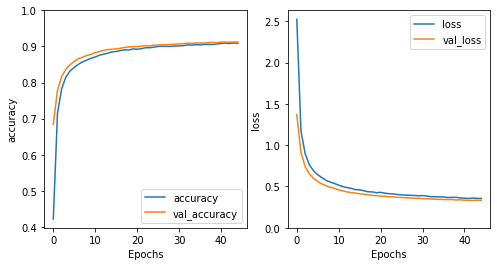

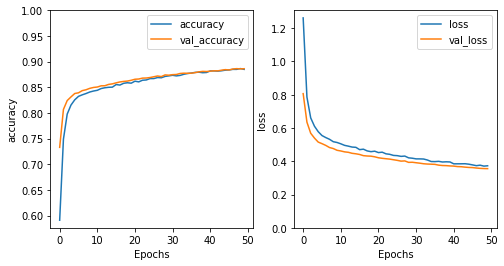

In [35]:
make_graphs(history)
make_graphs(history_B)

# PREDICTION

In [36]:
submit_input_data = pd.read_csv("../input/full-sentence-dataset/submitInput.csv")

In [37]:
df_submit = submit_input_data.iloc[:,1:2]
df_submit = df_submit.fillna('가')
df_submit.isna().sum()

0    0
dtype: int64

In [38]:
submision_input = np.array(df_submit)
submision_input = [str(submision_input[i]).replace('일 반','일반') for i in range(len(submision_input))]
submision_input = [str(submision_input[i]).replace('가지 고','가지다') for i in range(len(submision_input))]

In [39]:
predictions = model_A.predict(submision_input)
predictions_B = model_B.predict(submision_input)

In [40]:
prediction_to_index = list(map(tf.argmax, predictions))
prediction_to_index_B = list(map(tf.argmax, predictions_B))

In [41]:
prediction_to_index_list = list(map(int,prediction_to_index))
prediction_to_code = list(map(digit_2_code.get, prediction_to_index_list))
print(prediction_to_code[:5])

prediction_to_index_list_B = list(map(int,prediction_to_index_B))
prediction_to_code_B = list(map(digit_4_code.get, prediction_to_index_list_B))
print(prediction_to_code_B[:5])

[56, 46, 94, 47, 56]
['1', '6', '9', '2', '2']


In [42]:
table = code_table()
def transfer_to_group(member):
    cliped_member = str(member)
    return table[table['member'] == int(cliped_member)]['group'].iloc[0]

In [43]:
translated_member = list(map(transfer_to_group, prediction_to_code))
print(len(translated_member))

100000


In [44]:
df_0 = pd.DataFrame(translated_member, columns = ['digit_1'])
df_1 = pd.DataFrame(prediction_to_code, columns = ['digit_2'])
df_2 = pd.DataFrame(prediction_to_code_B, columns = ['digit_3'])
dfs = pd.concat([df_0,df_1], axis=1)

In [45]:
dfs['digit_3'] = df_1['digit_2'].astype(str) + df_2['digit_3']
dfs

,digit_1,digit_2,digit_3
0,I,56,561
1,G,46,466
2,S,94,949
3,G,47,472
4,I,56,562
...,...,...,...
99995,G,47,472
99996,Q,86,862
99997,G,47,472
99998,R,90,902


In [46]:
dfs.to_csv("solution.csv")

# COMPARE BY TEST DATA

In [47]:
def test_result(model, data, id_dic):
    test_predictions = model.predict(data)
    test_prediction_matrix = list(map(tf.argmax, test_predictions))
    predicted_id = list(map(int,test_prediction_matrix))
    test_prediction_to_code = list(map(id_dic.get, predicted_id))

    test_label_data_code = list(map(id_dic.get, test_label_data_B))
    
    test_df_pred = pd.DataFrame(test_prediction_to_code, columns = ['prediction'])
    test_df_label = pd.DataFrame(test_label_data_code, columns = ['label'])
    test_df_sentence = pd.DataFrame(data, columns = ['sentence'])
    test_dfs = pd.concat([test_df_pred,test_df_label,test_df_sentence], axis=1)
    return test_dfs

In [48]:
# test_dfs_B = test_result(model_B, test_input_data_B, digit_4_code)
# test_dfs_B = test_dfs_B[test_dfs_B['prediction'] != test_dfs_B['label']]

# plt.hist(test_dfs_B['label'])
# plt.show()

# test_dfs_B.to_csv("check.csv")